In [7]:
# Tool Setup

%load_ext tensorboard

import pathlib, os, sys, operator, re, datetime

from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Model
import tensorflow_datasets as tfds
import h5py
import pandas as pd

# Use seaborn for pairplot.
# pip install -q seaborn

import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.19.0


In [8]:
url = 'p:\Mitchell\FFNeuralNetwork\statsTraining.csv'

raw_dataset = pd.read_csv(url, na_values='?', comment='\t', skipinitialspace=True)

dataset = raw_dataset.copy()
# dataset.tail()

In [9]:
dataset.isna().sum()
dataset_clean = dataset.dropna(axis = 0, subset = 'Previous Rank')
# dataset = dataset.fillna(0)

# dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

dataset_clean.tail()

,Age,Previous Rank,FantPos,Games Played,Games Started,Cmp,Att,Yds,TD,Int,Rush Att,Rush Yds,Rush TD,Tgt,Rec,Rec Yds,Rec TD,Total TD,PPR,Rank
3240,24,526.0,1,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,627
3241,27,368.0,2,7,0,0.0,0.0,0.0,0.0,0.0,13.0,-13.0,0.0,0.0,0.0,0.0,0.0,0,-1.3,628
3242,24,205.0,0,4,1,0.0,0.0,0.0,0.0,0.0,14.0,16.0,0.0,6.0,5.0,14.0,0.0,0,4.0,629
3244,27,484.0,1,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0,-2.0,631
3245,29,455.0,1,17,0,0.0,0.0,0.0,0.0,0.0,1.0,-2.0,0.0,2.0,0.0,0.0,0.0,0,-2.2,632


In [10]:
train_dataset = dataset_clean.sample(frac=0.8, random_state=0)
test_dataset = dataset_clean.drop(train_dataset.index)

# sns.pairplot(train_dataset, diag_kind='kde')

train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Age,1894.0,26.758712,3.237290,21.0,24.00,26.0,28.0,45.0
Previous Rank,1894.0,282.615628,179.900748,1.0,127.25,262.0,425.0,690.0
FantPos,1894.0,1.369060,1.134166,0.0,1.00,1.0,2.0,4.0
Games Played,1894.0,11.229145,5.277135,0.0,7.00,13.0,16.0,17.0
Games Started,1894.0,5.527455,5.761324,0.0,0.00,3.0,10.0,17.0
Cmp,1893.0,20.075541,74.740022,0.0,0.00,0.0,0.0,490.0
Att,1893.0,30.895932,113.886531,0.0,0.00,0.0,0.0,733.0
Yds,1893.0,224.041204,840.501975,-7.0,0.00,0.0,0.0,5316.0
TD,1893.0,1.416799,5.679334,0.0,0.00,0.0,0.0,48.0
Int,1893.0,0.698891,2.609582,0.0,0.00,0.0,0.0,30.0


In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Rank')
test_labels = test_features.pop('Rank')

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Age,26.758712,3.237290
Previous Rank,282.615628,179.900748
FantPos,1.369060,1.134166
Games Played,11.229145,5.277135
Games Started,5.527455,5.761324
Cmp,20.075541,74.740022
Att,30.895932,113.886531
Yds,224.041204,840.501975
TD,1.416799,5.679334
Int,0.698891,2.609582


In [13]:
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[ 26.759 282.616   1.369  11.229   5.527     nan     nan     nan     nan
      nan     nan     nan     nan     nan     nan     nan     nan   2.224
      nan]]
First example: [[ 24.  363.    3.   15.    1.    0.    0.    0.    0.    0.    0.    0.
    0.    2.    2.   28.    0.    0.    4.8]]

Normalized: [[-0.85  0.45  1.44  0.71 -0.79   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan -0.72   nan]]


C:\Users\mdriscoll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
CPU times: total: 0 ns
Wall time: 0 ns
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


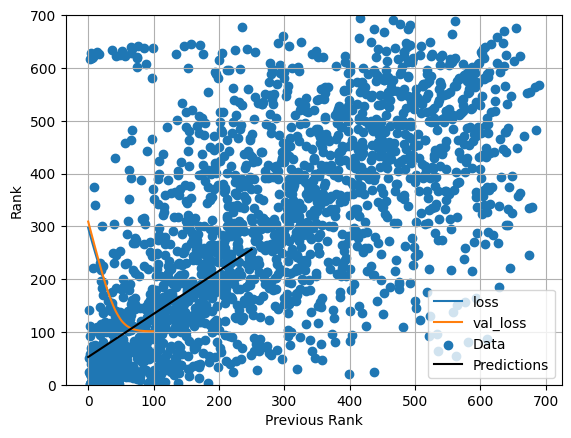

In [14]:
Previous_Rank = np.array(train_features['Previous Rank'])

Pre_normalizer = layers.Normalization(input_shape=[1,], axis=None)
Pre_normalizer.adapt(Previous_Rank)

Pre_model = tf.keras.Sequential([
    Pre_normalizer,
    layers.Dense(units=1)
])

Pre_model.summary()

Pre_model.predict(Previous_Rank[:10])

Pre_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

%time
history = Pre_model.fit(
    train_features['Previous Rank'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 700])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Rank]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

test_results = {}

test_results['Pre_model'] = Pre_model.evaluate(
    test_features['Previous Rank'],
    test_labels, verbose=0)

x = tf.linspace(0.0, 250, 251)
y = Pre_model.predict(x)

def plot_Rk(x, y):
  plt.scatter(train_features['Previous Rank'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Previous Rank')
  plt.ylabel('Rank')
  plt.legend()

plot_Rk(x, y)

In [15]:
# Takes 10 random Ranks Values and trys to predict the Previous Season Rank

print(Previous_Rank[:10])
# print(test_labels)

Pre_model.predict(Previous_Rank[:10])

[363. 576. 343. 425.  10. 353.  93. 300. 507.  83.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[348.499],
       [522.16 ],
       [332.193],
       [399.048],
       [ 60.695],
       [340.346],
       [128.366],
       [297.135],
       [465.904],
       [120.213]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
CPU times: total: 0 ns
Wall time: 0 ns


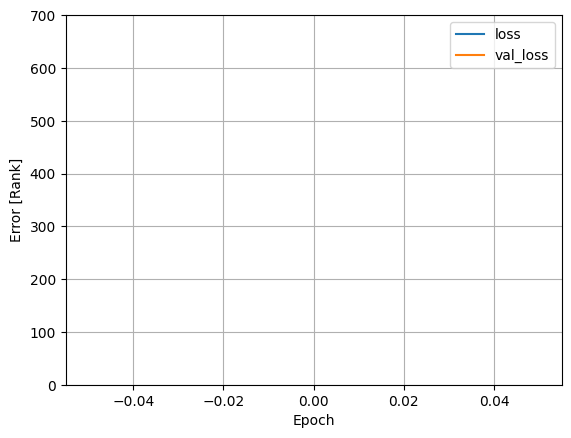

In [16]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [17]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_horsepower_model = build_and_compile_model(Rk_normalizer)

dnn_horsepower_model.summary()

%time
history = dnn_horsepower_model.fit(
    train_features['Rank'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_Rk(x, y)

test_results['dnn_rank_model'] = dnn_horsepower_model.evaluate(
    test_features['Rank'], test_labels,
    verbose=0)

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

NameError: name 'Rk_normalizer' is not defined

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Mean absolute error [Previous Rank]
Rk_model,160.001587
linear_model,153.102783
dnn_rank_model,160.010681
dnn_model,140.888016
reloaded,140.888016


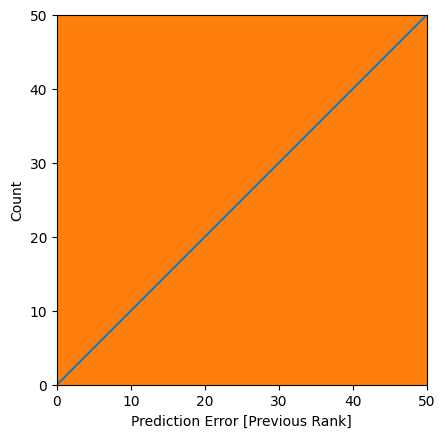

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [Previous Rank]']).T

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Previous Rank]')
plt.ylabel('Predictions [Previous Rank]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Previous Rank]')
_ = plt.ylabel('Count')

dnn_model.save('dnn_model.keras')

reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [Previous Rank]']).T